Para Verificar Performance da GPU Usar o Comando:

watch -n 1 amd-smi

# Setup do Projeto

In [1]:
import torch

# Setup Agnostic Code for GPU/CPU
if torch.cuda.is_available():
    device = 'cuda'
    print(f"CUDA está disponivel!\nDispositivo configurado para: {device}\nDevice count: {torch.cuda.device_count()}\nNome do dispositivo: {torch.cuda.get_device_name(0)}\nVersao do PyTorch: {torch.__version__}")
else:
    device = 'cpu'
    print(f"CUDA não está disponível.\nDispositivo configurado para: {device}\nVersao do PyTorch: {torch.__version__}")

CUDA está disponivel!
Dispositivo configurado para: cuda
Device count: 2
Nome do dispositivo: AMD Radeon RX 7800 XT
Versao do PyTorch: 2.9.1+rocm7.2.0.git7e1940d4


In [2]:
# Constantes
import os

DATA_PATH = '/home/jose-vitor/Documents/Cityscapes_Dataset'

IM_HEIGHT = 256
IM_WIDTH = 512

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() // 2

In [3]:
# Bibliotecas e imports
import custom_cityscapes as ccs
import custom_transforms as ctr
from utils import dataset_show

from torchvision import datasets
from torch.utils.data import DataLoader

# Preparando o Dataset Cityscapes

In [4]:
ds_lables = ccs.CityscapesLables()

# Imprimindo informacoes relevantes
print(f"O dataset possui {len(ds_lables.train_names_dict)} classes treinaveis:")
ds_lables.train_names_dict

O dataset possui 20 classes treinaveis:


{7: 'road',
 8: 'sidewalk',
 11: 'building',
 12: 'wall',
 13: 'fence',
 17: 'pole',
 19: 'traffic light',
 20: 'traffic sign',
 21: 'vegetation',
 22: 'terrain',
 23: 'sky',
 24: 'person',
 25: 'rider',
 26: 'car',
 27: 'truck',
 28: 'bus',
 31: 'train',
 32: 'motorcycle',
 33: 'bicycle',
 -1: 'ignore'}

In [5]:
# Imprimir o dictionário de mapeamento de ids originais para ids de treino
print("\nDicionário de mapeamento de ids originais para ids de treino:")
ds_lables.lable_conversion


Dicionário de mapeamento de ids originais para ids de treino:


{0: 19,
 1: 19,
 2: 19,
 3: 19,
 4: 19,
 5: 19,
 6: 19,
 7: 0,
 8: 1,
 9: 19,
 10: 19,
 11: 2,
 12: 3,
 13: 4,
 14: 19,
 15: 19,
 16: 19,
 17: 5,
 18: 19,
 19: 6,
 20: 7,
 21: 8,
 22: 9,
 23: 10,
 24: 11,
 25: 12,
 26: 13,
 27: 14,
 28: 15,
 29: 19,
 30: 19,
 31: 16,
 32: 17,
 33: 18}

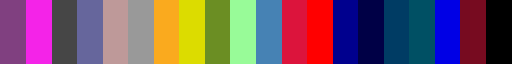

In [6]:
# Criando o colormap para as classes
cmap = ds_lables.get_cmap()
cmap

# Importar o Dataset Cityscapes

Definir Funções de Transform

In [7]:
custom_trans = ctr.Transforms(conv_size=(IM_HEIGHT, IM_WIDTH),
                              lable_conversion=ds_lables.lable_conversion)

Importar Dataset

In [8]:
train_dataset = ccs.AugmentedCityscapes(DATA_PATH,
                             split = 'train',
                             mode='fine',
                             target_type='semantic',
                             transform=custom_trans.train_transform,
                             target_transform=custom_trans.target_transform,
                             data_augmentation=custom_trans.data_augmentation)
val_dataset = datasets.Cityscapes(DATA_PATH,
                           split = 'val',
                           mode='fine',
                           target_type='semantic',
                           transform=custom_trans.val_transform,
                           target_transform=custom_trans.target_transform)
test_dataset = datasets.Cityscapes(DATA_PATH,
                            split = 'test',
                            mode='fine',
                            target_type='semantic',
                            transform=custom_trans.val_transform,
                            target_transform=custom_trans.target_transform)

In [9]:
# Imprimir informacoes importantes dos datasets
img, smnt = train_dataset[0]
print(f"O Dataset de treino possui {len(train_dataset)} amostras.\n"
      f"O Dataset de validação possui {len(val_dataset)} amostras.\n"
      f"O Dataset de teste possui {len(test_dataset)} amostras.\n"
      f"Cada imagem posssui tamanho {img.shape} e tipo {img.dtype}, e cada mascara possui tamanho {smnt.shape} e tipo {smnt.dtype}.\n")

#print(f"Primeira Imagem do dataset de treino:\n{img}\nPrimenra mascara do dataset de treino:\n{smnt}")

O Dataset de treino possui 2975 amostras.
O Dataset de validação possui 500 amostras.
O Dataset de teste possui 1525 amostras.
Cada imagem posssui tamanho torch.Size([3, 256, 512]) e tipo torch.float32, e cada mascara possui tamanho torch.Size([1, 256, 512]) e tipo torch.uint8.



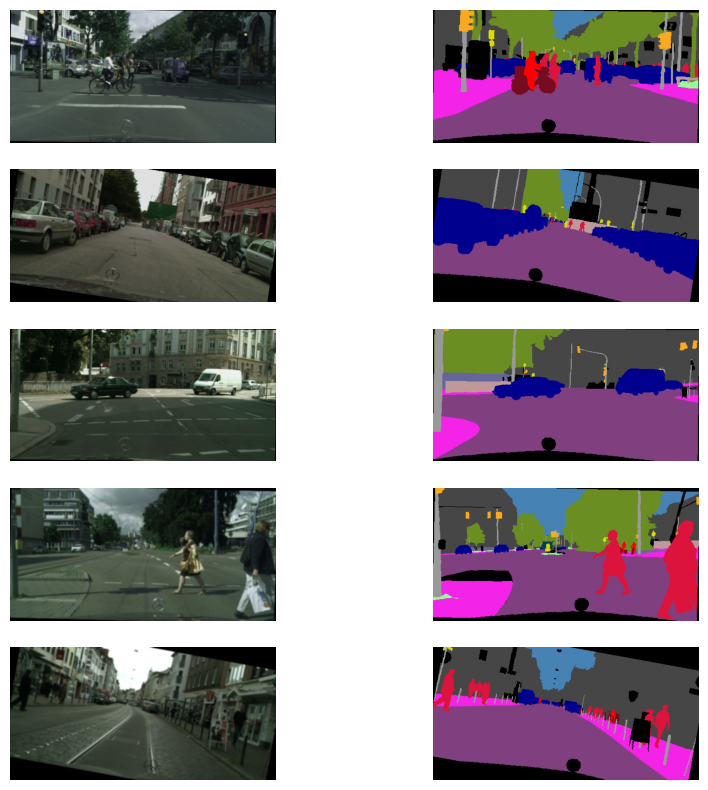

In [10]:
# Testando a funcao de exibicao
dataset_show(train_dataset, n=5, cmap=cmap)

Criar dataloaders

In [11]:
# Criando datalaoders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=True)

In [13]:
# Imprimindo informacoes relevantes dos dataloaders
train_features_batch, train_labels_batch = next(iter(train_dataloader))
val_features_batch, val_labels_batch = next(iter(val_dataloader))
print(f"O pacote de imagens para treino possui tamanho: {train_features_batch.size()}, e o tamanho do pacote da mescaras para treino possui tamanho: {train_labels_batch.size()}")
print(f"O pacote de imagens para validacao possui tamanho: {val_features_batch.size()}, e o tamanho do pacote da mescaras para validacao possui tamanho: {val_labels_batch.size()}")

O pacote de imagens para treino possui tamanho: torch.Size([32, 3, 256, 512]), e o tamanho do pacote da mescaras para treino possui tamanho: torch.Size([32, 1, 256, 512])
O pacote de imagens para validacao possui tamanho: torch.Size([32, 3, 256, 512]), e o tamanho do pacote da mescaras para validacao possui tamanho: torch.Size([32, 1, 256, 512])
